<a href="https://colab.research.google.com/github/jeetch/HE-Deep-Learning-Challenge-ResNet-Transfer-Learning/blob/master/MachineHack_DL_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" Imports """

import os
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda')

In [0]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

In [0]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [0]:
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(22, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [0]:
train_folder = '/content/drive/My Drive/DS Projects/HE DL challenge/dataset/train'
test_folder = '/content/drive/My Drive/DS Projects/HE DL challenge/dataset/test'

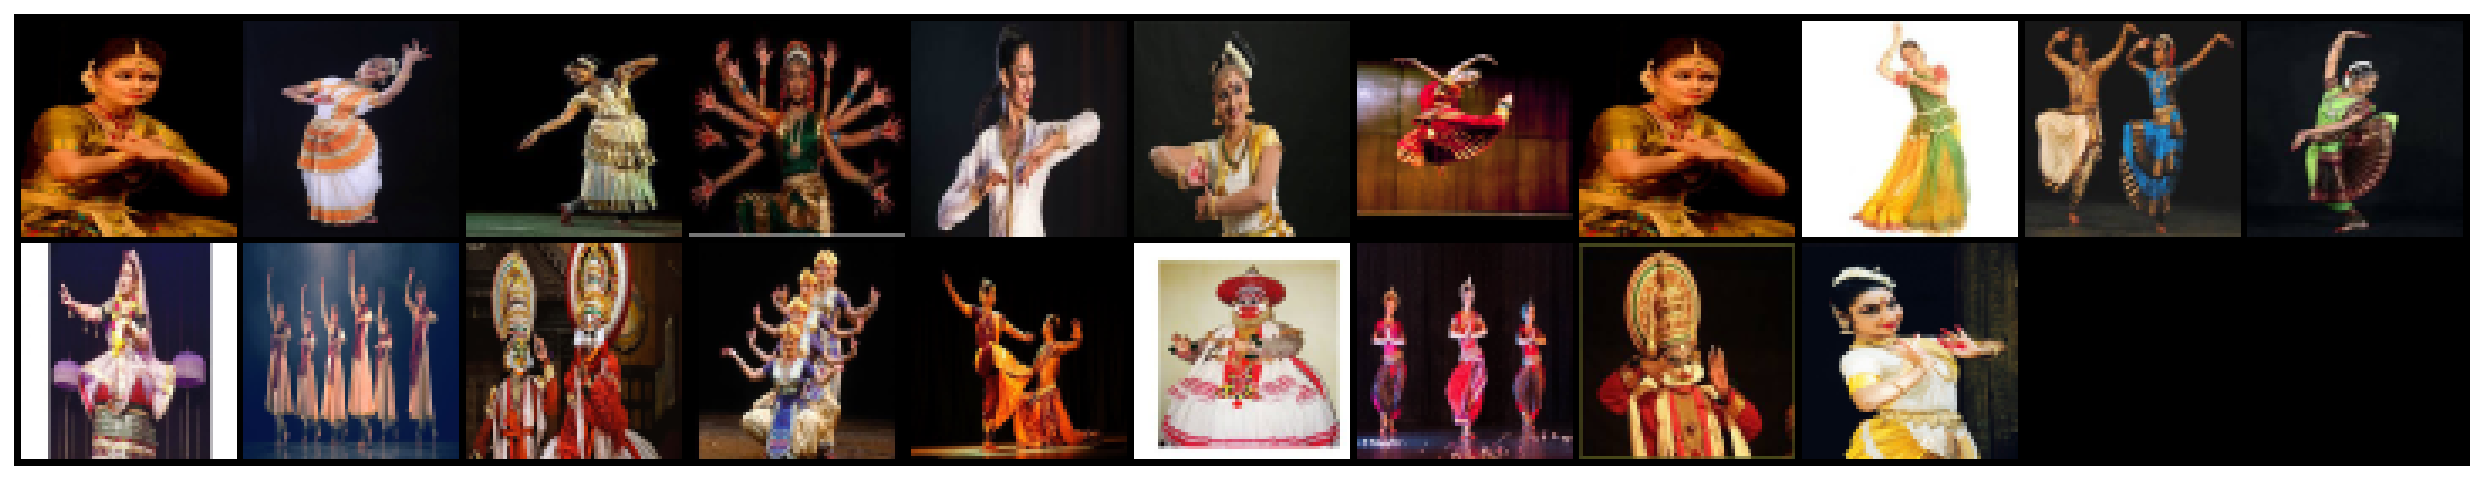

In [6]:
sample_images =[]
for i in range(20) :
  sample_images.append(np.random.choice(glob(f'{train_folder}/*jpg')))

show_sign_grid(sample_images)

In [0]:
train_labels = pd.read_csv('/content/drive/My Drive/DS Projects/HE DL challenge/dataset/train.csv')

In [0]:
class_names = train_labels.target.unique()

In [9]:
class_names

array(['manipuri', 'bharatanatyam', 'odissi', 'kathakali', 'kathak',
       'sattriya', 'kuchipudi', 'mohiniyattam'], dtype=object)

In [0]:
train_labels.head()
df= train_labels

In [11]:
df.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [12]:
df.loc[df['Image']=='96.jpg','target'].iloc[0]

'manipuri'

In [0]:
# for classn in class_names : 
#   for i in glob(f'{train_folder}/*jpg') :
#     if(df.loc[df['Image'] == os.path.basename(i),'target'].iloc[0] == classn):
#       print(classn)

In [0]:
DATA_DIR = '/content/drive/My Drive/DS Projects/HE DL challenge/'

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    path = os.path.join(DATA_DIR,ds,cls) 
    try: 
      os.mkdir(path) 
    except OSError as error: 
      print(error)

In [27]:
for classn in class_names:
  
  image_paths = []

  for i in glob(f'{train_folder}/*jpg') :
      if(df.loc[df['Image'] == os.path.basename(i),'target'].iloc[0] == classn):
        image_paths.append(i)
  class_name = classn
  
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

manipuri: 36
bharatanatyam: 47
odissi: 49
kathakali: 47
kathak: 44
sattriya: 45
kuchipudi: 46
mohiniyattam: 50


In [0]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [0]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

In [30]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 39, 'train': 288, 'val': 37}

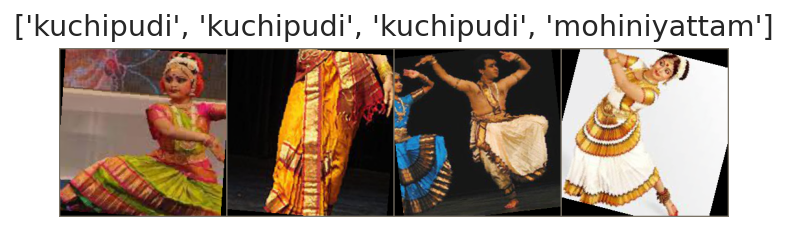

In [31]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using ResNet

In [0]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [33]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Training

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=100):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [124]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/100
----------
Train loss 0.8555862257877985 accuracy 0.736111111111111
Val   loss 1.00196715593338 accuracy 0.7297297297297298

Epoch 2/100
----------
Train loss 0.9343589527739419 accuracy 0.7013888888888888
Val   loss 1.302714329957962 accuracy 0.6756756756756757

Epoch 3/100
----------
Train loss 0.7100535184144974 accuracy 0.7708333333333333
Val   loss 0.9111869633197784 accuracy 0.7297297297297298

Epoch 4/100
----------
Train loss 0.8272835537791252 accuracy 0.7326388888888888
Val   loss 1.2164964377880096 accuracy 0.6756756756756757

Epoch 5/100
----------
Train loss 0.7777246307167742 accuracy 0.736111111111111
Val   loss 2.0536845088005067 accuracy 0.7027027027027027

Epoch 6/100
----------
Train loss 0.6984111447301176 accuracy 0.7638888888888888
Val   loss 1.197294330596924 accuracy 0.7297297297297298

Epoch 7/100
----------
Train loss 0.7682577727569474 accuracy 0.7708333333333333
Val   loss 1.3024296402931212 accuracy 0.7567567567567568

Epoch 8/100
----------
Tra

In [0]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

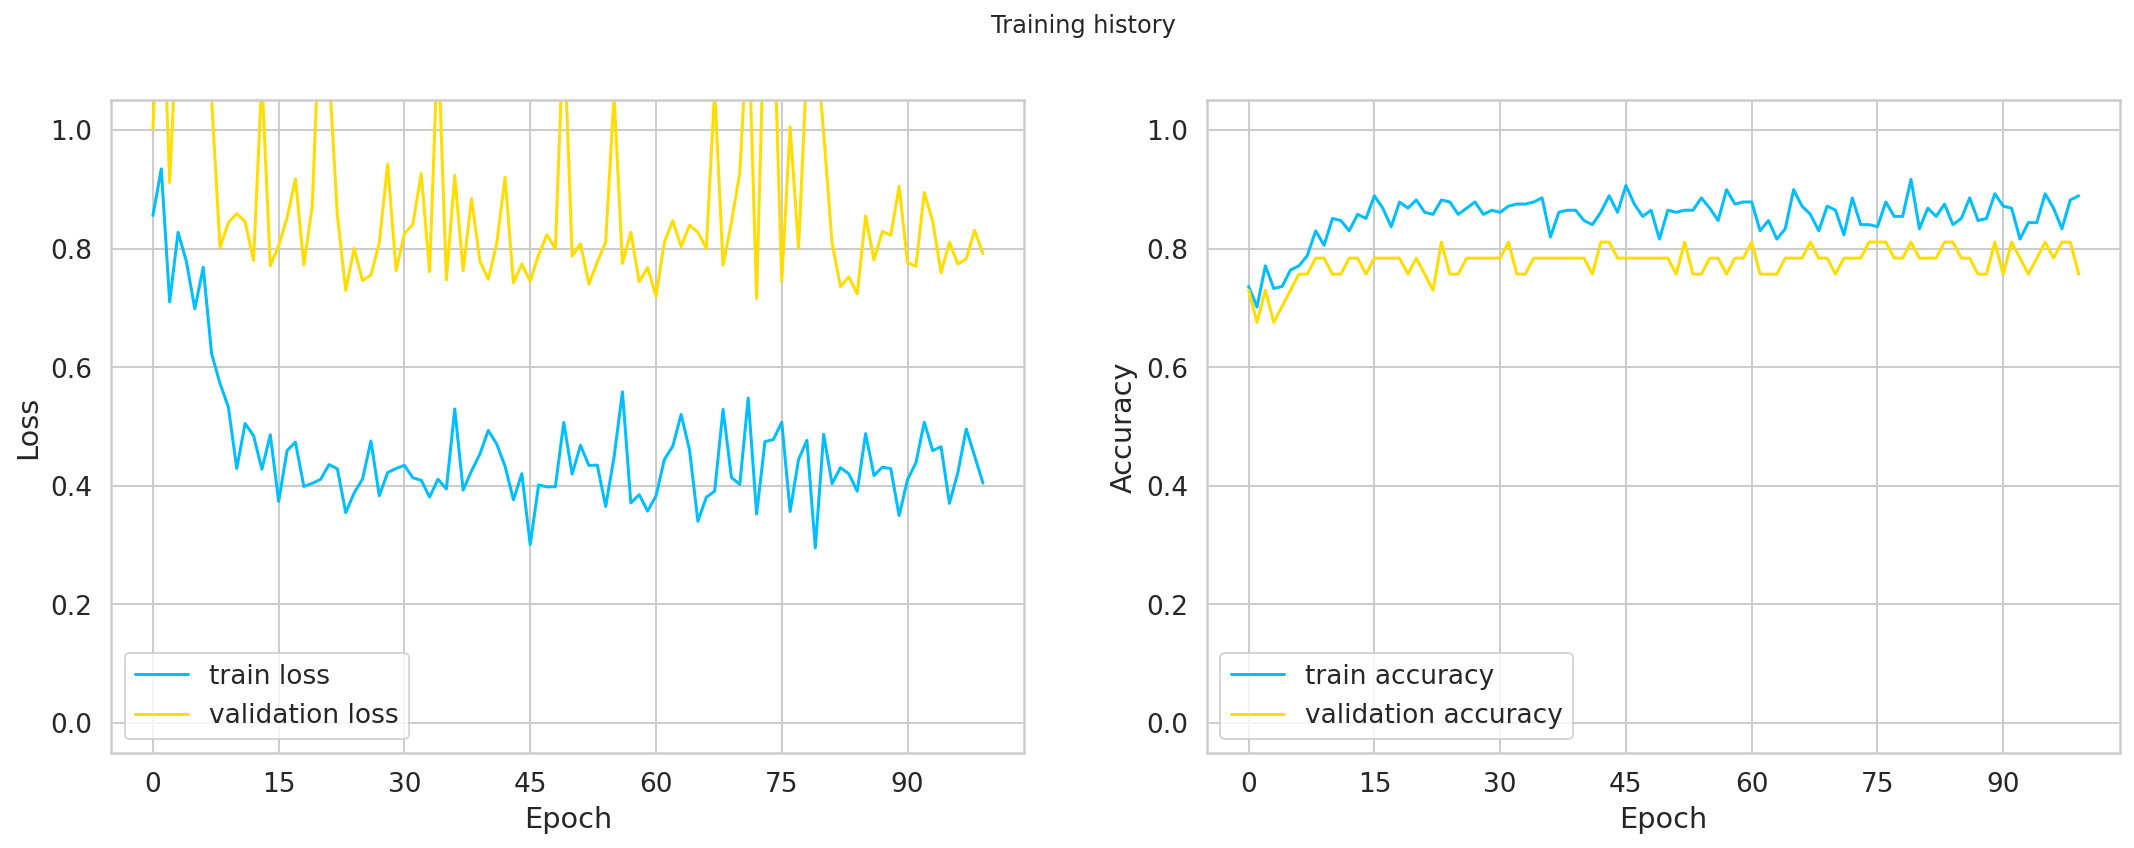

In [127]:
plot_training_history(history)

## Show Predictions

In [0]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'{class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

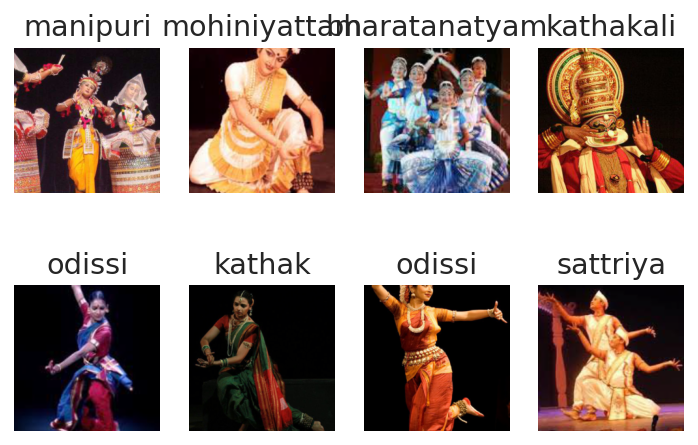

In [131]:
show_predictions(base_model, class_names, n_images=8)

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [0]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [134]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

bharatanatyam       0.71      1.00      0.83         5
       kathak       0.83      1.00      0.91         5
    kathakali       1.00      1.00      1.00         5
    kuchipudi       1.00      0.20      0.33         5
     manipuri       1.00      0.75      0.86         4
 mohiniyattam       1.00      1.00      1.00         5
       odissi       0.71      1.00      0.83         5
     sattriya       1.00      1.00      1.00         5

     accuracy                           0.87        39
    macro avg       0.91      0.87      0.85        39
 weighted avg       0.91      0.87      0.85        39



## Predict

In [0]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

In [0]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [0]:
test = pd.read_csv('/content/drive/My Drive/DS Projects/HE DL challenge/dataset/test.csv')
test_path = '/content/drive/My Drive/DS Projects/HE DL challenge/dataset/test'

In [0]:
from random import randint
random_img = test_path+"/"+test.iloc[randint(0,50),0]

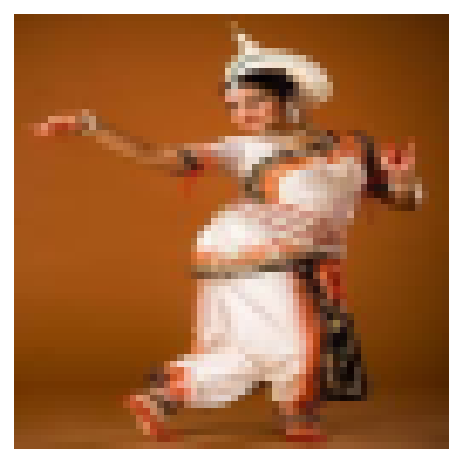

In [139]:
show_image(random_img)

In [140]:
pred = predict_proba(base_model, random_img)
class_names[np.argmax(pred)]

'kuchipudi'

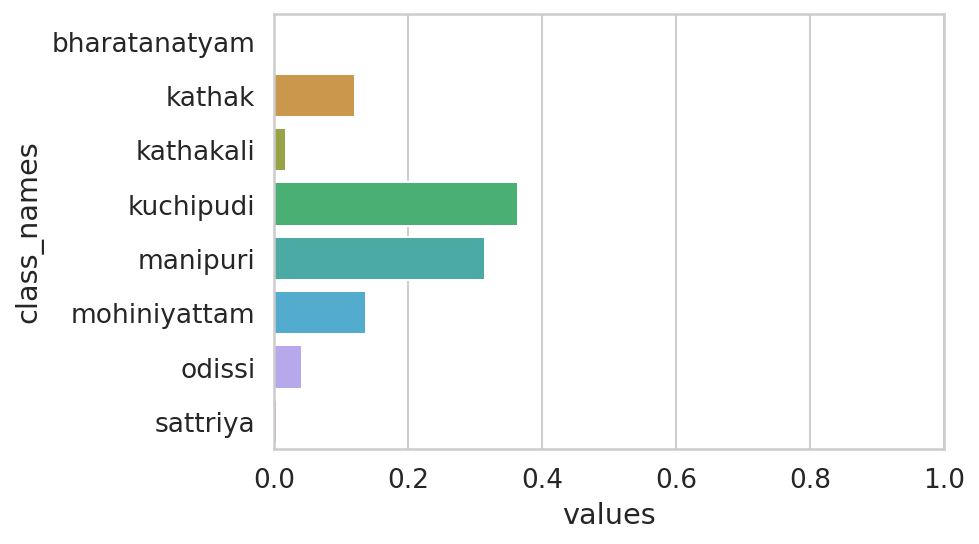

In [141]:
show_prediction_confidence(pred, class_names)

In [142]:
submission = pd.DataFrame(columns=["Image", "target"])

for i in range(len(test)) : 
  img = test.iloc[i,0]
  img_path = test_path+"/"+img
  pred = predict_proba(base_model, img_path)
  target = class_names[np.argmax(pred)]
  submission = submission.append({
     "Image": img,
     "target":  target
      }, ignore_index=True)
  print(img,target)

508.jpg bharatanatyam
246.jpg mohiniyattam
473.jpg odissi
485.jpg odissi
128.jpg bharatanatyam
410.jpg kuchipudi
465.jpg odissi
196.jpg kathakali
340.jpg sattriya
467.jpg odissi
306.jpg mohiniyattam
171.jpg bharatanatyam
323.jpg sattriya
332.jpg sattriya
330.jpg sattriya
170.jpg bharatanatyam
479.jpg odissi
9.jpg kathak
283.jpg mohiniyattam
114.jpg bharatanatyam
507.jpg odissi
183.jpg kathakali
200.jpg kathakali
457.jpg kuchipudi
264.jpg mohiniyattam
194.jpg kathakali
518.jpg odissi
175.jpg kuchipudi
64.jpg kathak
152.jpg bharatanatyam
270.jpg mohiniyattam
125.jpg kuchipudi
38.jpg kathak
440.jpg kuchipudi
302.jpg mohiniyattam
394.jpg kuchipudi
448.jpg odissi
463.jpg odissi
20.jpg kathak
301.jpg mohiniyattam
28.jpg kathak
61.jpg kathak
398.jpg bharatanatyam
349.jpg sattriya
271.jpg mohiniyattam
286.jpg sattriya
431.jpg manipuri
316.jpg sattriya
224.jpg kathakali
411.jpg kuchipudi
278.jpg mohiniyattam
456.jpg mohiniyattam
45.jpg kathak
324.jpg sattriya
6.jpg kathak
59.jpg sattriya
86.jpg

In [0]:
submission.to_csv('submission_100epoch.csv', index=False)